# This script compares the results from two different ways of computing EIBV

In [1]:
import numpy as np
from scipy.stats import mvn, norm
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from matplotlib.pyplot import get_cmap
from matplotlib import tri

nugget = .001

In [71]:

def EIBV_1D(threshold, mu, Sigma, F, R):
    Sigxi = Sigma @ F.T @ np.linalg.solve(F @ Sigma @ F.T + R, F @ Sigma)
    V = Sigma - Sigxi
    sa2 = np.diag(V).reshape(-1, 1)  # the corresponding variance term for each location
    IntA = 0.0
    for i in range(len(mu)):
        sn2 = sa2[i]
        m = mu[i]
        IntA = IntA + mvn.mvnun(-np.inf, threshold, m, sn2)[0] - mvn.mvnun(-np.inf, threshold, m, sn2)[0] ** 2
    return IntA

def EIBV(threshold, mu, Sig, F, R):
    
    pass


def get_ibv(mu, sigma_diag, threshold): 
    p = norm.cdf(threshold, mu, np.sqrt(sigma_diag))
    bv = p * (1 - p)
    ibv = np.sum(bv)
    return ibv
    
def get_eibv_field(mu, Sigma, threshold): 
    eibv_field = np.zeros_like(mu)
    for i in range(len(mu)):
        SF = Sigma[:, i].reshape(-1, 1)
        MD = 1 / (Sigma[i, i] + nugget)
        VR = SF @ SF.T * MD
        SP = Sigma - VR
        sigma_diag = np.diag(SP).reshape(-1, 1)
        eibv_field[i] = get_ibv(mu, sigma_diag, threshold)
    return eibv_field


def plotf_vector(xplot, yplot, values, title=None, alpha=None, cmap=get_cmap("BrBG", 10),
                 cbar_title='test', colorbar=True, vmin=None, vmax=None, ticks=None,
                 stepsize=None, threshold=None, polygon_border=None,
                 polygon_obstacle=None, xlabel=None, ylabel=None):
    """ Note for triangulation:
    - Maybe sometimes it cannot triangulate based on one axis, but changing to another axis might work.
    - So then the final output needs to be carefully treated so that it has the correct visualisation.
    - Also note, the floating point number can cause issues as well.
    """
    """ To show threshold as a red line, then vmin, vmax, stepsize, threshold needs to have values. """
    triangulated = tri.Triangulation(xplot, yplot)
    x_triangulated = xplot[triangulated.triangles].mean(axis=1)
    y_triangulated = yplot[triangulated.triangles].mean(axis=1)

#     ind_mask = []
#     for i in range(len(x_triangulated)):
#         ind_mask.append(is_masked(y_triangulated[i], x_triangulated[i]))

#     triangulated.set_mask(ind_mask)
    refiner = tri.UniformTriRefiner(triangulated)
    triangulated_refined, value_refined = refiner.refine_field(values.flatten(), subdiv=3)

    """ extract new x and y, refined ones. """
    # xre_plot = triangulated_refined.x
    # yre_plot = triangulated_refined.y
    ax = plt.gca()
    # ax.triplot(triangulated, lw=0.5, color='white')
    if np.any([vmin, vmax]):
        levels = np.arange(vmin, vmax, stepsize)
    else:
        levels = None
    if np.any(levels):
        linewidths = np.ones_like(levels) * .3
        colors = len(levels) * ['black']
        if threshold:
            dist = np.abs(threshold - levels)
            ind = np.where(dist == np.amin(dist))[0]
            linewidths[ind] = 10
            colors[ind[0]] = 'red'
        contourplot = ax.tricontourf(triangulated_refined, value_refined, levels=levels, cmap=cmap, alpha=alpha)
        ax.tricontour(triangulated_refined, value_refined, levels=levels, linewidths=linewidths, colors=colors,
                      alpha=alpha)
        # contourplot = ax.tricontourf(yre_plot, xre_plot, value_refined, levels=levels, cmap=cmap, alpha=alpha)
        # ax.tricontour(yre_plot, xre_plot, value_refined, levels=levels, linewidths=linewidths, colors=colors,
        #               alpha=alpha)
    else:
        contourplot = ax.tricontourf(triangulated_refined, value_refined, cmap=cmap, alpha=alpha)
        ax.tricontour(triangulated_refined, value_refined, vmin=vmin, vmax=vmax, alpha=alpha)
        # contourplot = ax.tricontourf(yre_plot, xre_plot, value_refined, cmap=cmap, alpha=alpha)
        # ax.tricontour(yre_plot, xre_plot, value_refined, vmin=vmin, vmax=vmax, alpha=alpha)

    if colorbar:
        cbar = plt.colorbar(contourplot, ax=ax, ticks=ticks)
        cbar.ax.set_title(cbar_title)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if np.any(polygon_border):
        plt.plot(polygon_border[:, 1], polygon_border[:, 0], 'k-.', lw=2)

    if np.any(polygon_obstacle):
        plt.plot(polygon_obstacle[:, 1], polygon_obstacle[:, 0], 'k-.', lw=2)
    return ax, value_refined

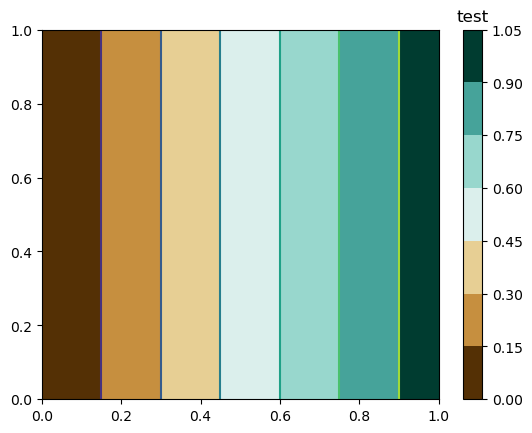

In [72]:
show_plot = False

""" Step I: Prepare the GRF field. """
xv = np.linspace(0, 1, 25)
yv = np.linspace(0, 1, 25)
xx, yy = np.meshgrid(xv, yv)
x = xx.flatten()
y = yy.flatten()
grid = np.stack((x, y), axis=1)

if show_plot: 
    plt.plot(grid[:, 0], grid[:, 1], 'k.')
    plt.gca().set_aspect("equal")
    plt.title("Grid discretization")
    plt.show()


""" Step II: calcuate the distance matrix. """
dm = cdist(grid, grid)

if show_plot: 
    plt.imshow(dm)
    plt.colorbar()
    plt.title("Distance matrix")
    plt.show()


""" Step III: calculate Matern covariance structure. """
sigma = 1.
phi = 4.5 / .5
Sigma = sigma**2 * (1 + phi * dm) * np.exp(-phi * dm)
if show_plot: 
    plt.imshow(Sigma)
    plt.colorbar()
    plt.title("Covariance matrix")
    plt.show()


""" Step IV: generate prior mean field. """
mu_prior = x
# mu = np.exp(((x - .5)**2 + (y - .5)**2))
# mu_truth = mu_prior.reshape(-1, 1) + np.linalg.cholesky(Sigma) @ np.random.randn(len(mu_prior)).reshape(-1, 1)
mu_truth = mu_prior
show_plot = True
if show_plot: 
    plotf_vector(x, y, mu_truth)
#     plt.scatter(x, y, c=mu_truth, s=200)
#     plt.colorbar()
#     plt.show()


""" Setup the EIBV calculation. """
threshold = .45


In [73]:
eibv = get_eibv_field(mu, Sigma, threshold)

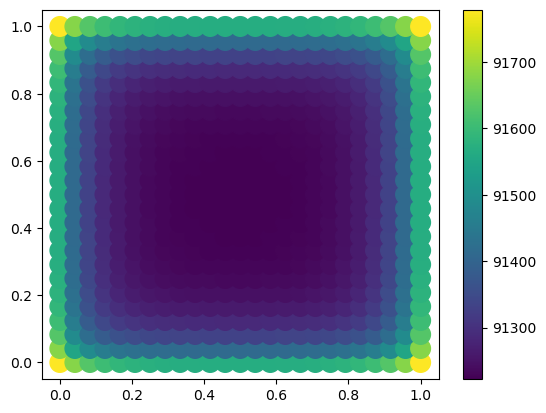

In [74]:
plt.scatter(x, y, c=eibv, s=200)
plt.colorbar()
plt.show()